In [1]:
from card_game import CardGame, Player, Card
import random
from agents import REINFORCEAgent, ACAgent, Agent, PPOAgent, RandomPlayer
from tqdm import tqdm
import numpy as np
import torch as t
from typing import Tuple, Union
from harry_plotter import LearningCurvePlot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import asyncio
from tqdm.notebook import tqdm

cividis = cm.get_cmap('cividis')
viridis = cm.get_cmap('viridis')
%matplotlib widget
player = 1

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%pip install ipympl


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!jupyter nbextension enable --py --sys-prefix ipympl

Enabling notebook extension jupyter-matplotlib/extension...
      - Validating: ok


In [5]:
min_loss = float('inf')
min_loss_baseline = float('inf')
min_loss_actor = float('inf')
min_loss_critic = float('inf')
min_loss_actor_ppo = float('inf')
min_loss_critic_ppo = float('inf')

In [6]:
def plot_loss_ac(loss: Tuple[float, float], agent: ACAgent, plot:LearningCurvePlot):
    global min_loss_actor, min_loss_critic
    actor, critic = loss
    if min_loss_actor > abs(actor): 
        min_loss_actor = abs(actor)
        t.save(agent.actor, "ac_actor.pkt")
        print(f"Upgraded actor loss to: {min_loss_actor}")
    if min_loss_critic > abs(critic): 
        min_loss_critic = abs(critic)
        t.save(agent.critic, "ac_critic.pkt")
        print(f"Upgraded critic loss to: {min_loss_critic}")
    plot.update({'One-Step Actor Critic loss':{'Actor':actor, "Critic":critic}})

def plot_loss(loss: float, agent: REINFORCEAgent, plot:LearningCurvePlot):
    global min_loss, min_loss_baseline
    loss, loss_baseline = loss
    if min_loss > abs(loss): 
        min_loss = abs(loss)
        t.save(agent.qnet, "reinforce.pkt")
        print(f"Upgraded loss to: {min_loss}")
    if min_loss_baseline > abs(loss_baseline): 
        min_loss_baseline = abs(loss_baseline)
        t.save(agent.baseline, "reinforce_baseline.pkt")
        print(f"Upgraded baseline loss to: {min_loss_baseline}")
    plot.update({'REINFORCE loss':{'Actor':loss,'Baseline':loss_baseline}})
    
def plot_loss_ppo(loss: Tuple[float, float], agent: PPOAgent, plot:LearningCurvePlot):
    global min_loss_actor_ppo, min_loss_critic_ppo
    actor, critic = loss
    if min_loss_actor_ppo > abs(actor): 
        min_loss_actor_ppo = abs(actor)
        t.save(agent.actor, "ppo_actor.pkt")
        print(f"Upgraded ppo-actor loss to: {min_loss_actor_ppo}")
    if min_loss_critic_ppo > abs(critic): 
        min_loss_critic_ppo = abs(critic)
        t.save(agent.critic, "ppo_critic.pkt")
        print(f"Upgraded ppo-critic loss to: {min_loss_critic_ppo}")
    plot.update({'PPO loss':{'Actor':abs(actor), "Critic":critic}})
 
def plot_invalid_actions(invalid_actions_count: int, agent: Agent, plot: LearningCurvePlot):
    name = agent.algorithm_name
    plot.update({'Invalid Actions':{name:invalid_actions_count}})
    
def plot_evaluation(times: int, agent: Agent, plot: LearningCurvePlot):
    name = agent.algorithm_name
    reward = 0
    agent.training = False
    eval_game = CardGame(agent, RandomPlayer(), RandomPlayer(), RandomPlayer(), display=False, delay=0.1, full_deck=False)
    for _ in range(times):
        reward += eval_game.start()[agent]
        
    agent.training = True
    plot.update({'Rewards':{name:reward/times}})

In [7]:
agent_ac= ACAgent(False, 1e-3, 1e-3, actor_layers=[256, 256, 128, 64], critic_layers=[256, 256, 128, 64], gamma=0.99995)
agent_pg = REINFORCEAgent(128, False, 3e-7, 3e-6, importance_weighting=True, queue_size=524288, baseline_layers=[256, 256, 128, 64], layers=[256, 256, 128, 64])
agent_ppo = PPOAgent(128, False, 1e-3, 1e-5, gamma=0.99, lambda_gae=0.95, update_interval=10, entropy_coeff=0.01, actor_layers=[128, 64, 32], critic_layers=[128, 64, 32])
# players = []
# for i in range(2):
#     # p = REINFORCEAgent(128, False, 5e-3, layers=[256, 256, 128, 64], queue_size=42024, importance_weighting=True)
#     # p.qnet = t.load("reinforce_256_128_128_64_small_deck.pkt")
#     # p.toggle_training(False)
#     # p.requires_grad_(False)
#     # p.eval()
#     # players.append(p)
#     players.append(RandomPlayer())

game = CardGame(agent_ac, agent_pg, agent_ppo, RandomPlayer(), full_deck=False, display=False)

In [8]:
agent_pg

REINFORCEAgent(
  (qnet): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (baseline): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_f

In [9]:
agent_ac

ACAgent(
  (actor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=

In [10]:
agent_ppo

PPOAgent(
  (actor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=32, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Identity()
    )
  )
)

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

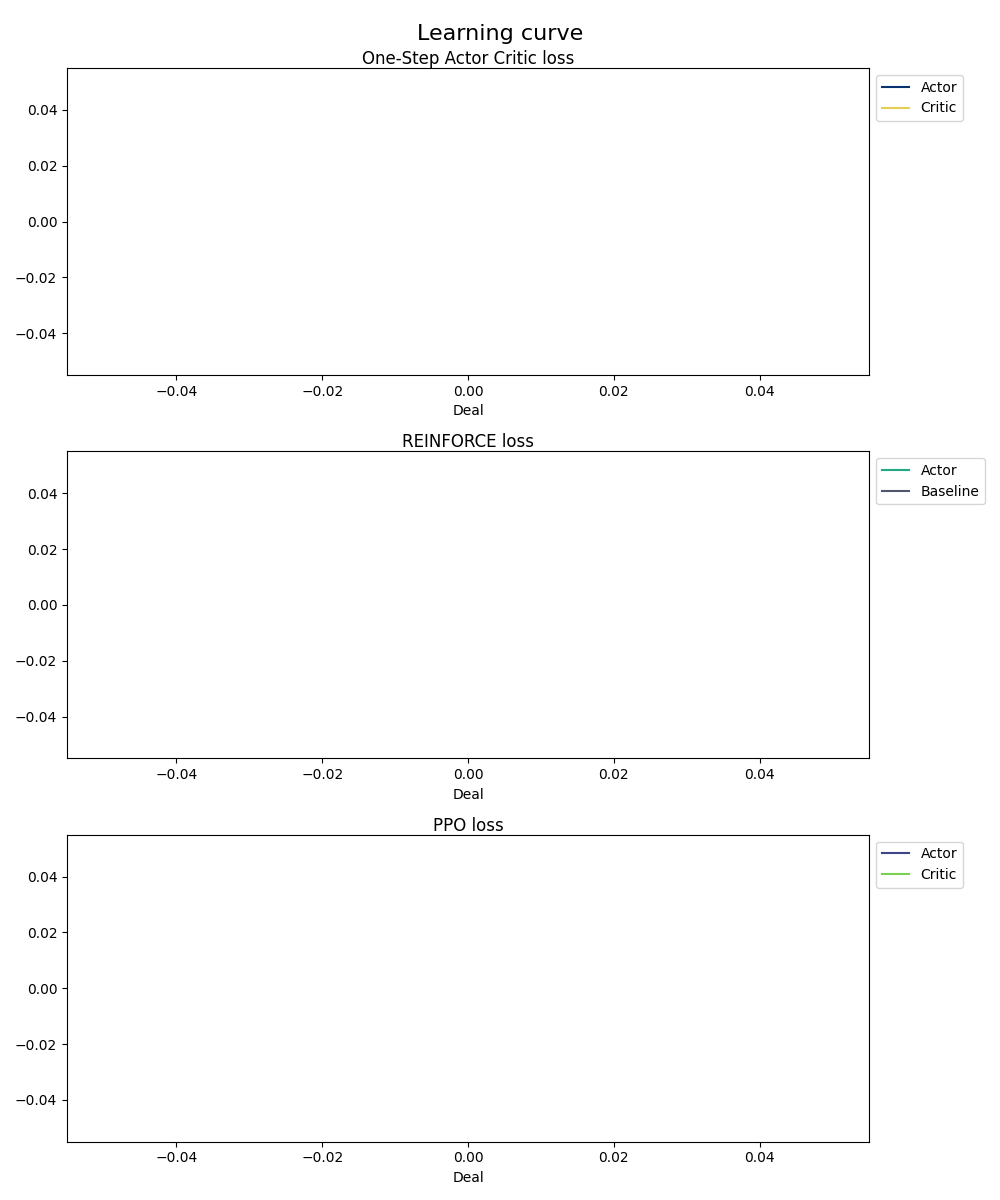

In [11]:
loop = tqdm(range(10000), desc="Episodes", position=0)
plot = LearningCurvePlot(plot_names=['One-Step Actor Critic loss', 'REINFORCE loss', 'PPO loss'],
                         line_names={'One-Step Actor Critic loss':['Actor', 'Critic'], 'REINFORCE loss':['Actor', 'Baseline'], 'PPO loss':['Actor', 'Critic']},
                         line_colors={'One-Step Actor Critic loss':[cividis(0.1), cividis(0.9)], 'REINFORCE loss':[viridis(0.6), cividis(0.3)], 'PPO loss':[viridis(0.2), viridis(0.8)]},
                         x_label='Deal')
agent_ac.set_loss_callback(lambda x: plot_loss_ac(x, agent_ac, plot))
agent_pg.set_loss_callback(lambda x: plot_loss(x, agent_pg, plot))
agent_ppo.set_loss_callback(lambda x: plot_loss_ppo(x, agent_ppo, plot))

async def learn():
    await asyncio.sleep(1)
    for _ in loop:
        game.start()
        loop.set_postfix({'REINFORCE loss':agent_pg.losses[-1] if agent_pg.losses else float('NaN'), "AC loss":agent_ac.losses[-1] if agent_ac.losses else float('NaN'), "PPO loss":agent_ppo.losses[-1] if agent_ppo.losses else float('NaN')})
        await asyncio.sleep(0.1)

task = asyncio.get_event_loop().create_task(learn())

In [12]:
await task

Upgraded loss to: 0.02546101245417615
Upgraded baseline loss to: 0.6368276216017821
Upgraded ppo-actor loss to: 0.45675154101574494
Upgraded ppo-critic loss to: 0.4470819065344074
Upgraded actor loss to: 57.818667558953166
Upgraded critic loss to: 16.558626662206127
Upgraded actor loss to: 44.07092036040766
Upgraded ppo-actor loss to: 0.3820553358666595
Upgraded ppo-critic loss to: 0.41616983977444305
Upgraded baseline loss to: 0.6198286073335437
Upgraded actor loss to: 10.6809121796063
Upgraded critic loss to: 7.024606569537094
Upgraded baseline loss to: 0.5550659461971317
Upgraded baseline loss to: 0.5518954459524001
Upgraded baseline loss to: 0.4667065231773324
Upgraded actor loss to: 5.555721913065229
Upgraded loss to: 0.013723476197023307
Upgraded ppo-actor loss to: 0.3642716931443385
Upgraded ppo-critic loss to: 0.3662132254413598
Upgraded ppo-actor loss to: 0.34358099621180704
Upgraded ppo-actor loss to: 0.2818638559560581
Upgraded baseline loss to: 0.4632101970501171
Upgraded c